In [ ]:
pip install requests pandas nltk textblob vaderSentiment

In [ ]:
pip install spacy transformers torch

In [ ]:
pip install numpy==1.26.4

In [ ]:
pip install kagglehub

In [ ]:
pip install matplotlib

In [ ]:
pip install scipy

In [ ]:
pip install bornrule

In [ ]:
pip install seaborn

In [ ]:
!python -m spacy download en_core_web_trf

In [ ]:
pip install rich

In [ ]:
pip install colorama

In [ ]:
pip install tabulate

In [ ]:
pip install gensim

In [ ]:
!python -m spacy download en_core_web_sm

# Import libraries

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from bornrule import BornClassifier
from nltk.corpus import stopwords
from tabulate import tabulate
from rich.table import Table
from rich.console import Console
from rich.box import MINIMAL, SQUARE
from gensim.models import KeyedVectors
from gensim.downloader import load as gensim_load
from gensim.models import Word2Vec
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification, pipeline
import re
import requests
import pandas as pd
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.special import softmax
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.cluster import KMeans
import numpy as np
import subprocess
from sklearn.metrics import accuracy_score
import json

In [63]:
console = Console()

# Importing stopwords list and wordnet

In [64]:
nltk.download('stopwords')
stop_words=stopwords.words('english')
stop_words.append("http")
stop_words.append("www")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/magdalenaskowerska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/magdalenaskowerska/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Tokenization function definition

In [65]:
def string_tokenization(string, stop_words):
    """ Tokenize strings in input
  Args:
    string (str): input string
    stop_words (list): input list of stop words to filter
  Returns:
    list: a list of tokens
  """
    token_list= [token for token in re.split(r'\W+', string.lower()) if token and len(token)>2]
    token_list = [t for t in token_list if not re.fullmatch(r'\d+(\.\d+)?([a-z]+)?', t)]
    token_list= [token for token in token_list if token not in stop_words]
    stemmer = PorterStemmer()
    token_list=[stemmer.stem(word) for word in token_list]
    
    lemmatizer = WordNetLemmatizer()
    token_list=[lemmatizer.lemmatize(word) for word in token_list]

    return token_list


# Data Import for training Born Classifier

In [66]:
fin_data_sent_df = pd.read_csv('financial_data.csv')

In [67]:
fin_data_sent_df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


## Data cleaning and preprocessing 

In [68]:
print(f"The data contains: {str(fin_data_sent_df.shape[0])} rows and {str(fin_data_sent_df.shape[1])} columns\n")
print("The columns are:")
for col in fin_data_sent_df.columns:
    print(f"- {col}")

The data contains: 5842 rows and 2 columns

The columns are:
- Sentence
- Sentiment


In [69]:
def check_null_values(df):
    """ Check the presence of null values and print the related information 
    Args:
    df: dataframe
    """
    null_values=[]
    
    for col in df.columns:
        for row in range(df.shape[0]):
            if df.iloc[row][col] is None:
                null_values.append([row, col, df.iloc[row][col]])
    
    if null_values:
        print(f"The total number of null values is: {len(null_values)}")
        print("The null values are at the following rows and columns: ")
        print(tabulate(null_values, headers=["Row", "Column", "Value"], tablefmt="pretty"))
    else:
        print("There are not null values")

    return 

In [70]:
check_null_values(fin_data_sent_df)

There are not null values


In [71]:
def df_column_stats(df):
    """ Print the statistics related to each column of a given dataframe
    Args:
    df: dataframe
    """
    col_names=["Column","Mean length","Median length","Max length", "Min length"]
    min_length_col_records=defaultdict(list)

    
    table = Table(title="Statistics", show_header=True, header_style="bold #0396D6", expand=True, box=SQUARE, padding=(1, 1))
    table.add_column("Column", style="dim")
    col_names=["Mean Length","Median length","Max length", "Min length"]
    for col in col_names:
        table.add_column(col, justify="center", style="#003B54")
    
    for col in df.columns:
        col_stats=[col]
        lengths = df[col].dropna().astype(str).apply(len)
        col_stats.append(round(lengths.mean(), 2))
        col_stats.append(round(lengths.max(), 2))
        col_stats.append(round(lengths.min(), 2))
        col_stats.append(round(lengths.median(), 2))

        min_length_records= df[col].dropna().astype(str)[lengths == lengths.min()]
        min_length_col_records[col].append(min_length_records.count())
        min_length_col_records[col].append(min_length_records.drop_duplicates().to_list())
        
        table.add_row(col_stats[0],str(col_stats[1]),str(col_stats[4]),str(col_stats[2]),str(col_stats[3]))

    console.print(table)

    for col, value in min_length_col_records.items():
        console.print(f"For column [italic bold]{col}[/italic bold] there are [bold #024D7D]{value[0]}[/bold #024D7D] records with min length: ")
        console.print(f"\t - The records with minimum length are: [#005A1B]{value[1]}[/#005A1B]")

    return

In [72]:
df_column_stats(fin_data_sent_df)

                                                    Statistics                                                     
┌────────────────────┬───────────────────────┬──────────────────────────┬────────────────────┬────────────────────┐
│                    │                       │                          │                    │                    │
│ Column             │      Mean Length      │      Median length       │     Max length     │     Min length     │
│                    │                       │                          │                    │                    │
├────────────────────┼───────────────────────┼──────────────────────────┼────────────────────┼────────────────────┤
│                    │                       │                          │                    │                    │
│ Sentence           │        117.02         │          107.0           │        315         │         9          │
│                    │                       │                          │                    │                    │
│                    │                       │                          │                    │                    │
│ Sentiment          │         7.46          │           7.0            │         8          │         7          │
│                    │                       │                          │                    │                    │
└────────────────────┴───────────────────────┴──────────────────────────┴────────────────────┴────────────────────┘

For column Sentence there are 1 records with min length:

- The records with minimum length are: ['Welcome !']

For column Sentiment there are 3130 records with min length:

- The records with minimum length are: ['neutral']

In [73]:
def length_distribution(df):
    """ Plot the length distribution of the dataframe columns
    Args:
    df: dataframe
    """
    num_cols = df.shape[1]
    fig, axes = plt.subplots(num_cols, 1, figsize=(8, 4 * num_cols), squeeze=False)

    for idx, col in enumerate(df.columns):
        lengths = df[col].dropna().astype(str).apply(len)
        dist = lengths.value_counts().sort_index()
        median_len = lengths.median()

        ax = axes[idx, 0]
        ax.bar(dist.index, dist.values, color='skyblue')
        ax.axvline(median_len, color='red', linestyle='--', linewidth=1, label=f'Median = {int(median_len)}')
        ax.set_title(f"Length Distribution ({col})", fontsize=14)
        ax.set_xlabel("N. of characters")
        ax.set_ylabel("N. of records")
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend()

    plt.tight_layout()
    plt.show()

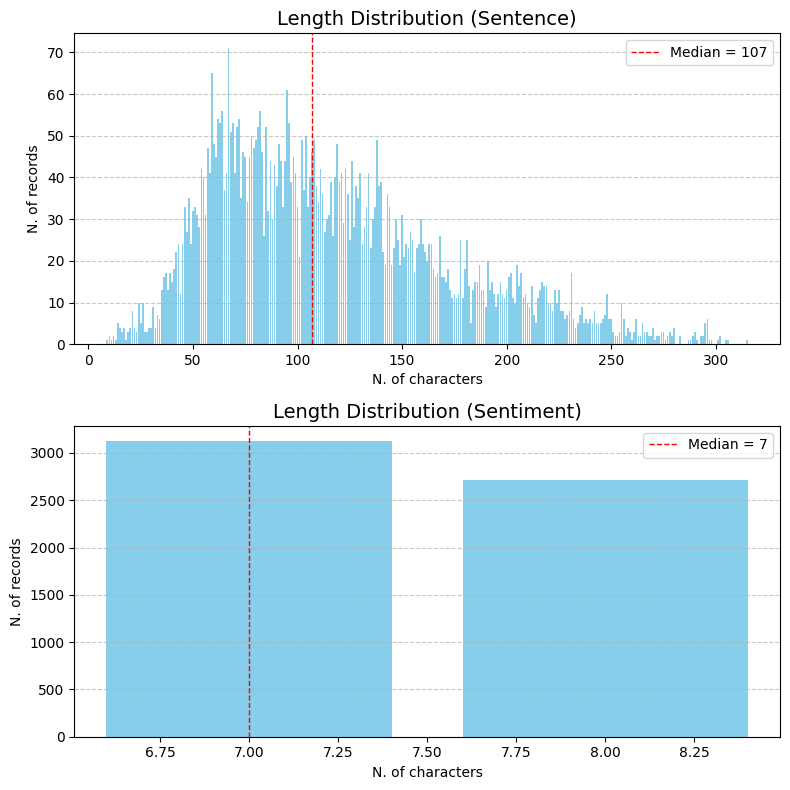

In [74]:
length_distribution(fin_data_sent_df)

In [75]:
mapping = {"negative": 0, "neutral": 1, "positive": 2}
fin_data_sent_df['Sentiment_mapping'] = fin_data_sent_df['Sentiment'].map(mapping)

# Tokenization removing stopwords

In [76]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda text: string_tokenization(text, stop_words))
tfidf_matrix = tfidf_vectorizer.fit_transform(fin_data_sent_df['Sentence'])

/Users/magdalenaskowerska/opt/anaconda3/envs/ABSA/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Born Classifier Training

In [77]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, fin_data_sent_df['Sentiment_mapping'], stratify=fin_data_sent_df['Sentiment_mapping'], test_size=0.20)

In [78]:
born = BornClassifier()
born.fit(X_train, y_train)
y_pred = born.predict(X_test)

In [79]:
console.print(classification_report(y_true=y_test, y_pred=y_pred))

precision    recall  f1-score   support

           0       0.38      0.60      0.47       172
           1       0.79      0.69      0.74       626
           2       0.72      0.67      0.70       371

    accuracy                           0.67      1169
   macro avg       0.63      0.66      0.63      1169
weighted avg       0.71      0.67      0.68      1169

# Extracting explanation features

In [80]:
global_e = born.explain()
features = tfidf_vectorizer.get_feature_names_out()
L = pd.DataFrame(global_e.toarray(), index=features, columns=[0,1,2])

In [81]:
explanatory_features_negative=list(L[0].sort_values(ascending=False).head(30).index)

In [82]:
explanatory_features_neutral=list(L[1].sort_values(ascending=False).head(30).index)

In [83]:
explanatory_features_positive=list(L[2].sort_values(ascending=False).head(30).index)

# Aspect extraction by using Named Entity Recognition (NER) model

In [84]:
model_name = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

def extract_aspects_from_sentence(sentence):
    entities = nlp_ner(sentence)
    return list(set(ent['word'].lower() for ent in entities))

fin_data_sent_df['Aspects'] = fin_data_sent_df['Sentence'].apply(extract_aspects_from_sentence)

aspects_extracted = []
for aspect_list in fin_data_sent_df['Aspects']:
    aspects_extracted.extend(aspect_list) 

aspects_extracted = list(set(aspects_extracted))

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


## Word Embedding for identifying aspects

## Identify aspects with "glove-wiki-gigaword-100" model

In [85]:
wv_glove = gensim_load("glove-wiki-gigaword-100")

In [86]:
def identify_aspects(word_vectors, explanatory_features, k=5):
    """ Identify aspects by grouping words related to it and using a pre-trained
        embedding model
    Args:
    word_vectors: embedding pre-trained set of word vectors
    explanatory_features(list): list of words representing the explanatory festures
    k(int): number of aspects with the default value equal to three
    
    Returns:
    aspect_clusters(dict): dictionary of aspects and the related words
    """
    
    filtered_keywords = [word for word in explanatory_features if word in word_vectors]
    filtered_word_vectors = np.array([word_vectors[word] for word in filtered_keywords])
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(filtered_word_vectors)

    aspect_clusters = defaultdict(list)
    
    for word, label in zip(filtered_keywords, labels):
        aspect_clusters[f"Aspect_{label}"].append(word)
    
    return aspect_clusters

In [87]:
aspect_clusters_glove=identify_aspects(wv_glove, aspects_extracted)

#for aspect, words in aspect_clusters_glove.items():
#    print(f"\n{aspect}: {words}")

## Identify aspects with Word2Vec model trained with financial data taken from NEWS API

In [88]:
def get_password(account, service):
    """
    Get password saved on local Mac Keychain Access
    
    Args:
    account(string): username
    service(string): service name
    
    Returns:
    password(string): password
    """
    command = [
        'security', 'find-generic-password',
        '-a', account,
        '-s', service,
        '-w'
    ]
    result = subprocess.run(command, capture_output=True, text=True)
    
    if result.returncode != 0:
        raise Exception(f"Error retrieving password: {result.stderr.strip()}")
    
    return result.stdout.strip()


In [89]:
def get_newsapi_articles(query="market", language="en", num_articles=100, n_pages=5):
    """ Get news articles from NewsAPI
    
    Args:
    query(string): query string
    language(string): language with the default value of english
    num_articles(int): number of articles with the default value of 100
    n_pages(int): number of pages with the default value of 5
    
    Returns:
    df: dataframe 
    
    """
    articles=[]
    for page in range(1, n_pages + 1):
        
        url = f"https://newsapi.org/v2/everything?q={query}&language={language}&page={page}&apiKey={NEWSAPI_KEY}"
        response = requests.get(url)

        if response.status_code==200:
            data = response.json()

            if data.get("status") == "ok":
                articles.extend(data["articles"])

    if articles:
        df = pd.DataFrame(articles)[["title", "description", "url"]]
        return df
    else:
        print("Error fetching NewsAPI data:", data)
        return None

In [90]:
NEWSAPI_KEY = get_password('USER1', 'NEWSAPI_KEY')
df_newsapi = get_newsapi_articles()
df_newsapi.head(10)

,title,description,url
0,The Nissan Leaf Is Back And Looking to Make Up...,Fresh details of the 2026 Nissan Leaf show big...,https://www.wired.com/story/the-nissan-leaf-is...
1,Our Favorite Solar Wireless Outdoor Camera Dro...,This is the easiest outdoor security camera to...,https://gizmodo.com/this-great-solar-wireless-...
2,TP-Link AX1800 WiFi 6 Router Gets Second Price...,The TP-Link AX21 is certainly one of the most ...,https://gizmodo.com/tp-link-ax1800-wifi-6-rout...
3,Spike in Pancreas Problems From Weight-Loss Dr...,Over 100 cases of acute pancreatitis have been...,https://gizmodo.com/spike-in-pancreas-problems...
4,Israeli strike at Gaza market kills 18 Palesti...,Witnesses said Israeli drones fired at Hamas p...,https://www.bbc.com/news/articles/cly8dlzx918o
5,LLMs are optimizing the adult industry,When Ela Darling began performing in porn at t...,https://www.theverge.com/ai-artificial-intelli...
6,Microsoft just teased its next-gen Xbox consol...,"I feel like a broken record, but I've been wri...",https://www.theverge.com/notepad-microsoft-new...
7,Joby delivers first aircraft to Dubai as air t...,Joby Aviation is getting ready to take flight....,https://www.theverge.com/news/694515/joby-deli...
8,Ketamine swapped for salt as smugglers exploit...,Crime gangs are using increasingly elaborate r...,https://www.bbc.com/news/articles/c201jjgkvjlo
9,Meta’s AI copyright win comes with a warning a...,Meta won a major legal ruling in an AI copyrig...,https://www.theverge.com/news/693437/meta-ai-c...


### Data Cleaning NEWSAPI data

In [91]:
print(f"The data contains: {str(df_newsapi.shape[0])} rows and {str(df_newsapi.shape[1])} columns\n")
print("The columns are:")
for col in df_newsapi.columns:
    print(f"- {col}")

The data contains: 500 rows and 3 columns

The columns are:
- title
- description
- url


In [92]:
check_null_values(df_newsapi)

The total number of null values is: 20
The null values are at the following rows and columns: 
+-----+-------------+-------+
| Row |   Column    | Value |
+-----+-------------+-------+
| 14  | description |       |
| 36  | description |       |
| 37  | description |       |
| 38  | description |       |
| 40  | description |       |
| 41  | description |       |
| 73  | description |       |
| 74  | description |       |
| 75  | description |       |
| 76  | description |       |
| 77  | description |       |
| 78  | description |       |
| 120 | description |       |
| 121 | description |       |
| 172 | description |       |
| 173 | description |       |
| 174 | description |       |
| 242 | description |       |
| 245 | description |       |
| 247 | description |       |
+-----+-------------+-------+


In [93]:
df_column_stats(df_newsapi)

                                                    Statistics                                                     
┌──────────────────────┬──────────────────────┬─────────────────────────┬────────────────────┬────────────────────┐
│                      │                      │                         │                    │                    │
│ Column               │     Mean Length      │      Median length      │     Max length     │     Min length     │
│                      │                      │                         │                    │                    │
├──────────────────────┼──────────────────────┼─────────────────────────┼────────────────────┼────────────────────┤
│                      │                      │                         │                    │                    │
│ title                │        72.52         │          71.0           │        177         │         11         │
│                      │                      │                         │                    │                    │
│                      │                      │                         │                    │                    │
│ description          │        153.82        │          143.0          │        260         │         30         │
│                      │                      │                         │                    │                    │
│                      │                      │                         │                    │                    │
│ url                  │        93.37         │          94.0           │        172         │         21         │
│                      │                      │                         │                    │                    │
└──────────────────────┴──────────────────────┴─────────────────────────┴────────────────────┴────────────────────┘

For column title there are 1 records with min length:

- The records with minimum length are: ['Grab and go']

For column description there are 1 records with min length:

- The records with minimum length are: ['Smart Beta ETF report for JPME']

For column url there are 1 records with min length:

- The records with minimum length are: ['https://citronics.eu/']

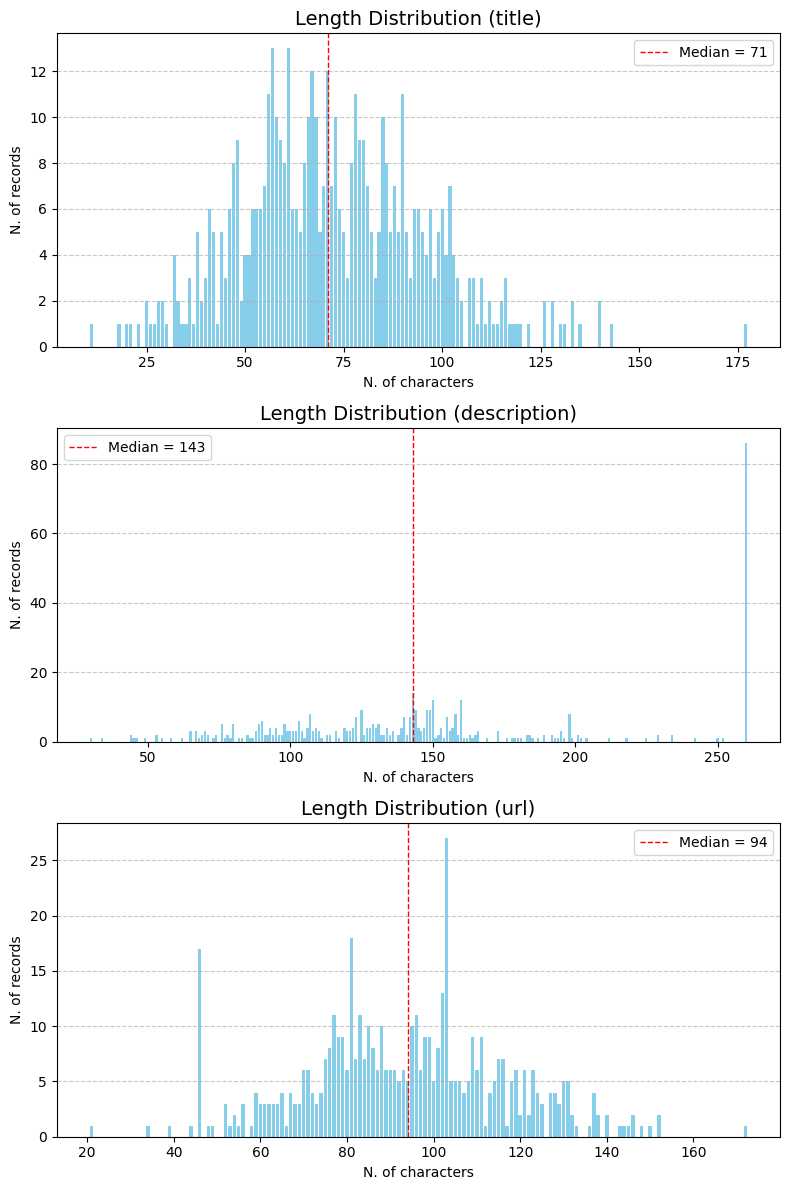

In [94]:
length_distribution(df_newsapi)

In [95]:
sentences=[string_tokenization(string, stop_words) for string in df_newsapi["description"] if string is not None]

In [96]:
sentences.extend([string_tokenization(string, stop_words) for string in df_newsapi["title"] if string is not None])

### Train Word2Vec model and identify aspects

In [97]:
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [98]:
wv_newsapi = model.wv 

In [99]:
aspect_clusters_newsapi=identify_aspects(wv_newsapi, aspects_extracted)

#for aspect, words in aspect_clusters_newsapi.items():
#    print(f"\n{aspect}: {words}")

# Map sentence to aspect

In [100]:
sentence_to_aspects_newsapi={}

for idx, row in df_newsapi.iterrows():
    aspects=set()
    
    title = row['title']
    if title is not None:
        tokenized_title=string_tokenization(title, stop_words)
        for aspect_label, aspect_words in aspect_clusters_newsapi.items():
            if any(word in aspect_words for word in tokenized_title):
                aspects.add(aspect_label)
        if aspects:
            sentence_to_aspects_newsapi[title]=[tokenized_title, list(aspects)]
        
    description = row['description']
    if description is not None:
        tokenized_description=string_tokenization(description, stop_words)
        for aspect_label, aspect_words in aspect_clusters_newsapi.items():
            if any(word in aspect_words for word in tokenized_description):
                aspects.add(aspect_label)
        if aspects:        
            sentence_to_aspects_newsapi[description]=[tokenized_description, list(aspects)]

In [101]:
def records_per_aspect_distribution(sentence_to_aspects: dict):
    """
    Calculate and plot the number of records per aspect

    Args:
    sentence_to_aspects(dict): dictionary with sentences each represented by list of words and list of aspects
    """
    n_records_aspect=defaultdict(int)

    for key, value in sentence_to_aspects.items():
        aspects = value[1]
        
        for aspect in aspects:
            n_records_aspect[aspect]+=1
            

    for key, value in n_records_aspect.items():
        print(f"The number of records for the aspect {key} is: {value}")
    
        
    fig, ax = plt.subplots(figsize=(10, 5))

    aspects = list(n_records_aspect.keys())
    counts = list(n_records_aspect.values())
    
    ax.bar(aspects, counts, color='skyblue')
    ax.set_title("Number of Records per Aspect", fontsize=14)
    ax.set_xlabel("Aspect")
    ax.set_ylabel("Number of Records")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    

# Sentiment analysis per each sentence and aspect

In [102]:
def extract_context(tokenized_sentence, aspect_keywords, window_size=5):
    """
    Given a tokenized sentence and a list of aspect words, return a string of joined context windows,
    where each context window is a string containing words around an aspect term.

    Args:
    tokenized_sentence(list): list of words representing the sentence
    aspect_keywords(list): list of aspect words

    Returns:
    context: string representing the context extracted from the sentence
    
    """
    contexts = []
    for idx, word in enumerate(tokenized_sentence):
        if word.lower() in aspect_keywords:
            start = max(idx - window_size, 0)
            end = min(idx + window_size + 1, len(tokenized_sentence))
            context = tokenized_sentence[start:end]
            contexts.append(" ".join(context))
    return " ".join(contexts)


In [103]:
def sentiment_aspect_sentence(sentence_to_aspects: dict,  model, vectorizer, aspect_clusters: dict = None) -> dict:
    """
    Define Sentiment with a pre-trained model for each sentence and aspect associated with it

    Args:
    sentence_to_aspects(dict): dictionary with sentences each represented by list of words and list of aspects
    aspect_clusters(dict): dictionary with aspects labels as keys and list of words associated with it
    model: pre-trained model to use for snetiment prediction that takes in input the vectorized sentence as list of float numbers
    vectorizer: vectorizer used for the training process of the model in input

    Returns:
    dictionary: sentence as key and list of {'aspect': string, 'sentiment': int} as value
    
    """

    sentence_aspect_sentiment=defaultdict(list)

    for key, value in sentence_to_aspects.items():
        tokenized_sentence=value[0]
        aspects=value[1]
        aspect_related_words=[]
        
        for aspect in aspects:
            if aspect_clusters:
                aspect_related_words=aspect_clusters[aspect]
            else:
                aspect_related_words=[aspect]
                
            if any(word in tokenized_sentence for word in aspect_related_words):
                aspect_occurrences = [word for word in tokenized_sentence if word in aspect_related_words]
                
                sentiment_votes = []
            
                for word in aspect_occurrences:
                    context = extract_context(tokenized_sentence, [word])
                    vec_sentence = vectorizer.transform([context])
                    sentiment_pred = model.predict(vec_sentence)
                    sentiment_votes.append(sentiment_pred[0])
                
                if sentiment_votes:
                    majority_sentiment = Counter(sentiment_votes).most_common(1)[0][0]
                    sentence_aspect_sentiment[key].append({'aspect': aspect, 'sentiment': majority_sentiment})
                
    return sentence_aspect_sentiment
        
    

The number of records for the aspect Aspect_1 is: 514
The number of records for the aspect Aspect_2 is: 193
The number of records for the aspect Aspect_3 is: 114
The number of records for the aspect Aspect_4 is: 187
The number of records for the aspect Aspect_0 is: 106


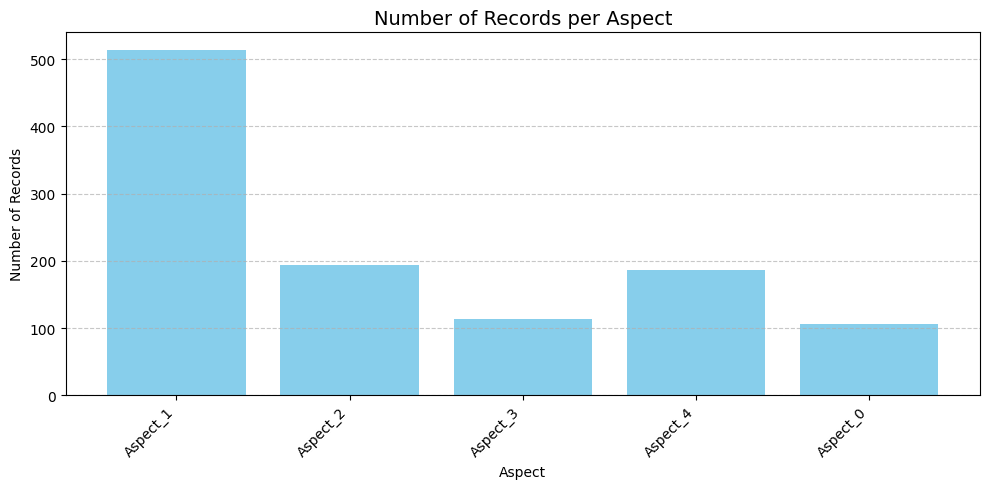

In [104]:
records_per_aspect_distribution(sentence_to_aspects_newsapi)

In [105]:
sentence_aspect_sentiment_newsapi=sentiment_aspect_sentence(sentence_to_aspects_newsapi, born, tfidf_vectorizer, aspect_clusters_newsapi)

# Evaluate Born model based on SEntFiN 1.0 dataset

In [106]:
sentfin_df = pd.read_csv(r"SEntFiNv1.1.csv")
sentfin_df.head()

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [107]:
print(f"The data contains: {str(sentfin_df.shape[0])} rows and {str(sentfin_df.shape[1])} columns\n")
print("The columns are:")
for col in sentfin_df.columns:
    print(f"- {col}")

The data contains: 10753 rows and 4 columns

The columns are:
- S No.
- Title
- Decisions
- Words


In [108]:
check_null_values(sentfin_df)

There are not null values


In [109]:
df_column_stats(sentfin_df)

                                                    Statistics                                                     
┌────────────────────┬───────────────────────┬──────────────────────────┬────────────────────┬────────────────────┐
│                    │                       │                          │                    │                    │
│ Column             │      Mean Length      │      Median length       │     Max length     │     Min length     │
│                    │                       │                          │                    │                    │
├────────────────────┼───────────────────────┼──────────────────────────┼────────────────────┼────────────────────┤
│                    │                       │                          │                    │                    │
│ S No.              │         3.97          │           4.0            │         5          │         1          │
│                    │                       │                          │                    │                    │
│                    │                       │                          │                    │                    │
│ Title              │         58.7          │           57.0           │        135         │         18         │
│                    │                       │                          │                    │                    │
│                    │                       │                          │                    │                    │
│ Decisions          │         33.66         │           29.0           │        140         │         17         │
│                    │                       │                          │                    │                    │
│                    │                       │                          │                    │                    │
│ Words              │         1.54          │           2.0            │         2          │         1          │
│                    │                       │                          │                    │                    │
└────────────────────┴───────────────────────┴──────────────────────────┴────────────────────┴────────────────────┘

For column S No. there are 9 records with min length:

- The records with minimum length are: ['1', '2', '3', '4', '5', '6', '7', '8', '9']

For column Title there are 2 records with min length:

- The records with minimum length are: ['NTPC files for FPO', "Gold's allure dims"]

For column Decisions there are 13 records with min length:

- The records with minimum length are: ['{"OI": "neutral"}', '{"IT": "neutral"}', '{"GE": "neutral"}', 
'{"3i": "neutral"}', '{"US": "neutral"}', '{"EY": "neutral"}', '{"B": "negative"}', '{"G": "negative"}']

For column Words there are 4982 records with min length:

- The records with minimum length are: ['8', '7', '6', '5', '4', '9', '3']

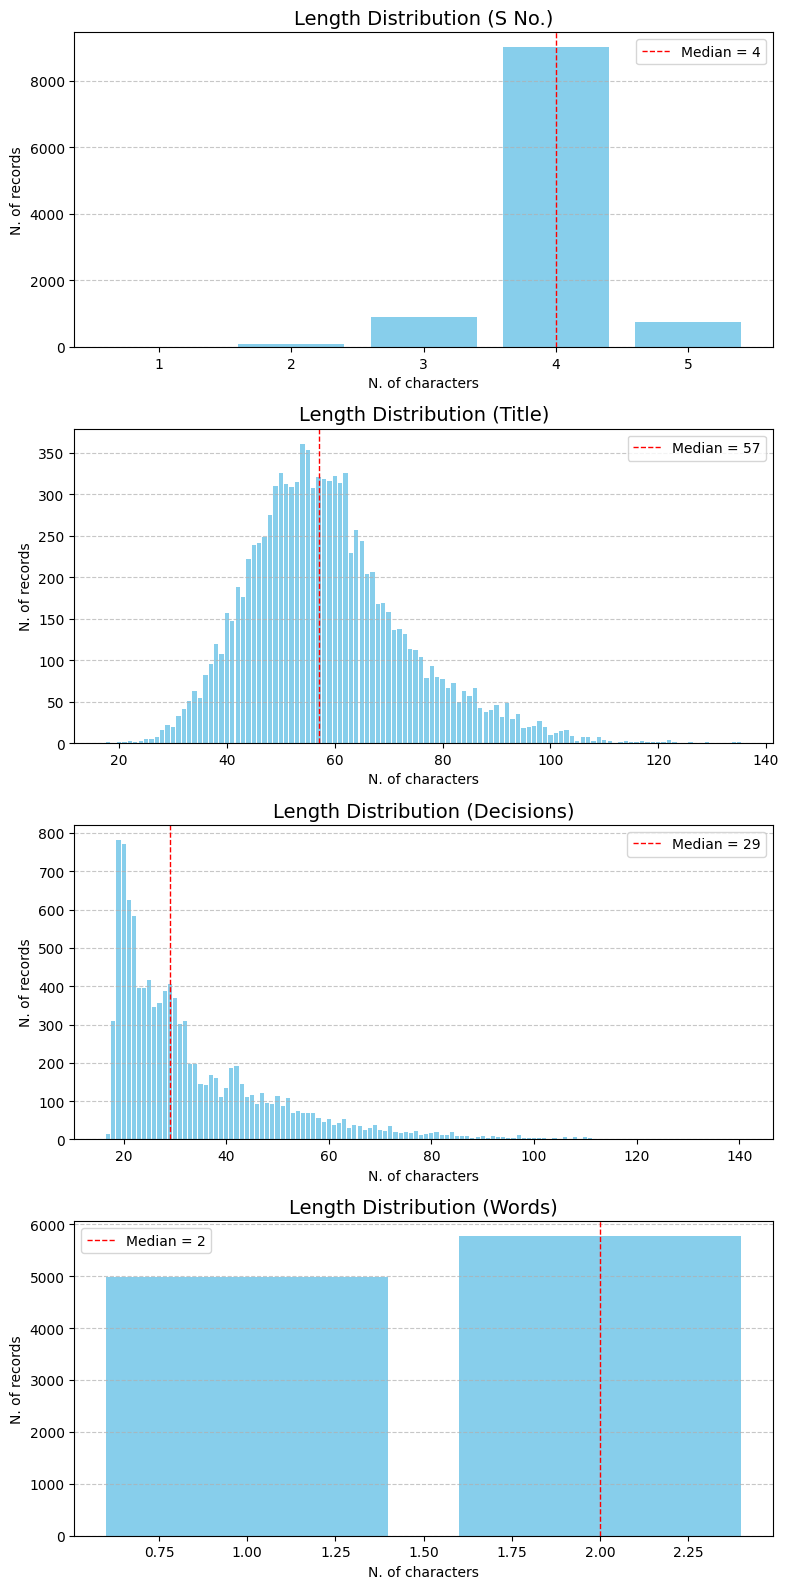

In [110]:
length_distribution(sentfin_df)

In [111]:
sentence_aspect_sentiment_sentfin=defaultdict(list)
sentence_to_aspects_sentfin={}

for idx, row in sentfin_df.iterrows():
    title = row['Title']
    tokenized_title=string_tokenization(title, stop_words)
    decisions = json.loads(row['Decisions'])
    aspects=[]
        
    for aspect, sentiment_pred in decisions.items():
        sentence_aspect_sentiment_sentfin[title].append({
            'aspect': aspect,
            'sentiment': mapping[sentiment_pred]
        })
        aspects.append(aspect)

    sentence_to_aspects_sentfin[title]=[tokenized_title, aspects]

In [112]:
sentence_aspect_sentiment_sentfin_pred=sentiment_aspect_sentence(sentence_to_aspects_sentfin,born, tfidf_vectorizer)

In [113]:
def calculate_accuracy(predictions_model_A: dict, predictions_model_B: dict) -> float:
    """
    Calculate the accuracy by comparing the sentiment predictions of Model A with Model B

    Args:
    predictions_model_A(dict): sentence as key and list of {'aspect': string, 'sentiment': int} as value
    predictions_model_B(dict): sentence as key and list of {'aspect': string, 'sentiment': int} as value

    Returns:
    float: accuracy score comparing sentiments from both models
    """

    model_A_predictions = []
    model_B_predictions = []
    predictions_per_aspect=defaultdict(lambda: {"model_A_predictions": [], "model_B_predictions": []})

    for sentence, aspects_A in predictions_model_A.items():
        aspects_B = predictions_model_B.get(sentence, [])
        aspect_sentiment_B = {entry['aspect']: entry['sentiment'] for entry in aspects_B}

        for item in aspects_A:
            aspect = item['aspect']
            sentiment_A = item['sentiment']
            
            if aspect in aspect_sentiment_B:
                sentiment_B = aspect_sentiment_B[aspect]
                model_A_predictions.append(sentiment_A)
                model_B_predictions.append(sentiment_B)
                predictions_per_aspect[aspect]["model_A_predictions"].append(sentiment_A)
                predictions_per_aspect[aspect]["model_B_predictions"].append(sentiment_B)

    #for aspect, predictions in predictions_per_aspect.items():
    #    print(f"For aspect {aspect} :")
    #    print(classification_report(predictions_per_aspect[aspect]["model_A_predictions"], predictions_per_aspect[aspect]["model_B_predictions"], zero_division=0))

    return classification_report(model_A_predictions, model_B_predictions, zero_division=0)


In [114]:
classification_report_sentfin = calculate_accuracy(sentence_aspect_sentiment_sentfin, sentence_aspect_sentiment_sentfin_pred)
console.print("Classification Report considering all aspects: ")
console.print(classification_report_sentfin)

Classification Report considering all aspects:

precision    recall  f1-score   support

           0       0.59      0.60      0.60       226
           1       0.33      0.19      0.25       159
           2       0.57      0.74      0.65       226

    accuracy                           0.55       611
   macro avg       0.50      0.51      0.50       611
weighted avg       0.52      0.55      0.52       611

The number of records for the aspect SpiceJet is: 20
The number of records for the aspect MMTC is: 9
The number of records for the aspect Mid-cap funds is: 1
The number of records for the aspect Mid caps is: 1
The number of records for the aspect Market is: 26
The number of records for the aspect Infosys is: 131
The number of records for the aspect Hudco is: 2
The number of records for the aspect HOEC is: 2
The number of records for the aspect Gold is: 121
The number of records for the aspect Silver is: 18
The number of records for the aspect Genpact is: 5
The number of records for the aspect EXL is: 1
The number of records for the aspect Bharti Airtel is: 27
The number of records for the aspect banking is: 8
The number of records for the aspect Centrum Broking is: 3
The number of records for the aspect Aurobindo Pharma is: 13
The number of records for the aspect MSCI is: 13
The number of records for the aspect India index is: 1
The number of records for the aspect Ashok Leyland is: 21

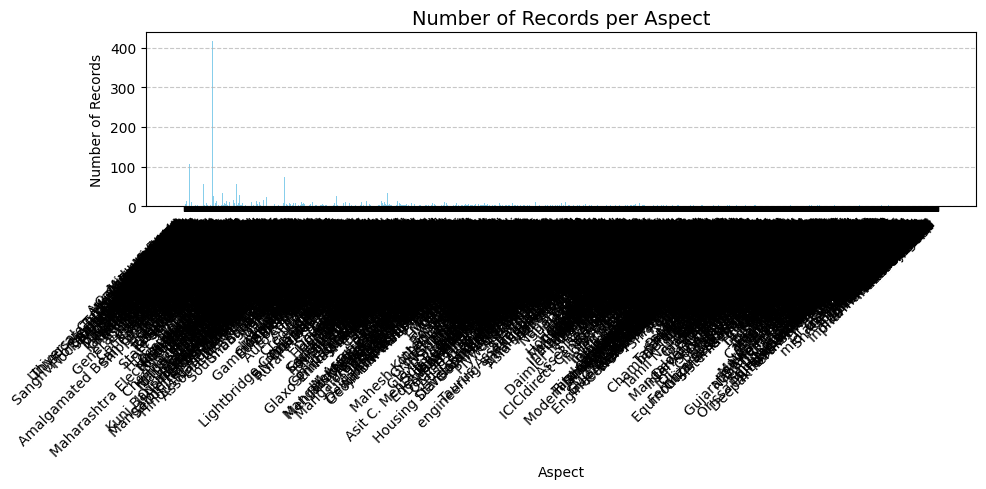

In [116]:
records_per_aspect_distribution(sentence_to_aspects_sentfin)

# Model evaluation with FinBERT

In [117]:
MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [118]:
def sentiment_aspect_sentence_bert(sentence_to_aspects: dict , model, tokenizer, aspect_clusters: dict=None) -> dict:
    """
    Define Sentiment with a pre-trained BERT model for each sentence and aspect associated with it

    Args:
    sentence_to_aspects(dict): dictionary with sentences each represented by list of words and list of aspects
    aspect_clusters(optional): dictionary with aspects labels as keys and list of words associated with it
    model: BERT model
    tokenizer: corresponding tokenizer

    Returns:
    dictionary: sentence as key and list of {'aspect': string, 'sentiment': int} as value
    """

    sentence_aspect_sentiment = defaultdict(list)

    for key, value in sentence_to_aspects.items():
        tokenized_sentence = key.split()
        aspects = value[1]
        aspect_related_words=[]
        
        for aspect in aspects:
            if aspect_clusters:
                aspect_related_words=aspect_clusters[aspect]
            else:
                aspect_related_words=[aspect]
            
            if any(word in tokenized_sentence for word in aspect_related_words):
                context = extract_context(tokenized_sentence, aspect_related_words)

                inputs = tokenizer(context, return_tensors="pt", padding=True, truncation=True)

                with torch.no_grad():
                    outputs = model(**inputs)
                    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                    predicted_class = torch.argmax(probs, dim=1).item()

                    sentence_aspect_sentiment[key].append({
                        'aspect': aspect,
                        'sentiment': predicted_class
                    })

    return sentence_aspect_sentiment


## Comparison with Born

In [119]:
sentence_aspect_sentiment_bert=sentiment_aspect_sentence_bert(sentence_to_aspects_newsapi, model, tokenizer, aspect_clusters_newsapi)

In [120]:
classification_report_newsapi_bert = calculate_accuracy(sentence_aspect_sentiment_newsapi, sentence_aspect_sentiment_bert)
console.print(classification_report_newsapi_bert)

precision    recall  f1-score   support

           0       0.18      0.11      0.14        63
           1       0.28      0.14      0.19       136
           2       0.32      0.62      0.42        96

    accuracy                           0.29       295
   macro avg       0.26      0.29      0.25       295
weighted avg       0.27      0.29      0.25       295

## FinBERT evaluation on Sentfin data

In [121]:
sentence_aspect_sentiment_sentfin_pred_bert=sentiment_aspect_sentence_bert(sentence_to_aspects_sentfin,model, tokenizer)

In [122]:
classification_report_sentifn_bert = calculate_accuracy(sentence_aspect_sentiment_sentfin_pred_bert,sentence_aspect_sentiment_sentfin)
console.print(classification_report_sentifn_bert)

precision    recall  f1-score   support

           0       0.02      0.14      0.04       264
           1       0.01      0.13      0.03       303
           2       0.88      0.28      0.43      5715

    accuracy                           0.27      6282
   macro avg       0.31      0.18      0.16      6282
weighted avg       0.80      0.27      0.39      6282